In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.metrics import precision_score, recall_score, f1_score

from utils.dataset import IDC_Dataset, load_dataset, create_transforms
from utils.models import ConvNet

In [2]:
# Desactivem un warning de pytorch que podem ignorar (https://github.com/pytorch/pytorch/issues/97207)
import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                        message='TypedStorage is deprecated')


In [3]:
# Carreguem el dataset a partir del path on es troben les imatges
base_path = "./dataset/IDC_regular_ps50_idx5"
images, labels, metadata = load_dataset(base_path)

# Calcular mitjana i desviació estàndard per a normalitzar les imatges
mean = np.mean(images, axis=(0, 1, 2)) / 255
std = np.std(images, axis=(0, 1, 2)) / 255

data_transforms = create_transforms(mean, std)


Carregant imatges IDC-positives...: 100%|██████████| 78786/78786 [00:27<00:00, 2875.80it/s]


In [4]:
def train_loop(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels, _ in tqdm(train_loader, desc=f"TRAINING EPOCH {epoch + 1}/{num_epochs}", unit=" batches"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)
            total_samples += len(labels)

        train_losses.append(running_loss / total_samples)
        train_accuracies.append(running_corrects.item() / total_samples)

        val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_loop(
            model, val_loader, criterion, device)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)

    return train_losses, val_losses, train_accuracies, val_accuracies, val_precisions, val_recalls, val_f1_scores


def evaluate_loop(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)
            total_samples += len(labels)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return (running_loss / total_samples,
            running_corrects.item() / total_samples,
            precision,
            recall,
            f1)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

k_folds = 5
num_epochs = 10
batch_size = 32

learning_rates = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

gkf = GroupKFold(n_splits=k_folds)

lr_results = []

for lr_value in learning_rates:
    print(f"Entrenant model amb lr {lr_value}...")
    for train_idx, val_idx in gkf.split(images, labels, [md[0] for md in metadata]):
        train_set = IDC_Dataset(
            images[train_idx], labels[train_idx], metadata[train_idx], transform=data_transforms)
        val_set = IDC_Dataset(
            images[val_idx], labels[val_idx], metadata[val_idx], transform=data_transforms)

        train_loader = DataLoader(
            train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(
            val_set, batch_size=batch_size, shuffle=False)

        model = ConvNet().to(device)

        optimizer = torch.optim.AdamW(
            model.parameters(), lr=lr_value)
        criterion = nn.BCELoss()

        train_losses, val_losses, train_accuracies, val_accuracies, val_precisions, val_recalls, val_f1_scores = train_loop(
            model, train_loader, val_loader, optimizer, criterion, num_epochs, device
        )

        lr_results.append({
            "lr": lr_value,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies,
            "val_precisions": val_precisions,
            "val_recalls": val_recalls,
            "val_f1_scores": val_f1_scores
        })


Entrenant model amb lr 5e-05...


TRAINING EPOCH 10/10: 100%|██████████| 6881/6881 [00:52<00:00, 129.97 batches/s]


Entrenant model amb lr 0.0001...


TRAINING EPOCH 10/10: 100%|██████████| 6881/6881 [00:52<00:00, 130.71 batches/s]


Entrenant model amb lr 0.0005...


TRAINING EPOCH 10/10: 100%|██████████| 6881/6881 [00:52<00:00, 131.52 batches/s]


Entrenant model amb lr 0.001...


TRAINING EPOCH 10/10: 100%|██████████| 6881/6881 [00:48<00:00, 142.17 batches/s]


Entrenant model amb lr 0.005...


TRAINING EPOCH 10/10: 100%|██████████| 6881/6881 [00:49<00:00, 139.76 batches/s]


Entrenant model amb lr 0.01...


TRAINING EPOCH 10/10: 100%|██████████| 6881/6881 [00:49<00:00, 139.93 batches/s]


Entrenant model amb lr 0.05...


TRAINING EPOCH 2/10: 100%|██████████| 6880/6880 [00:51<00:00, 133.27 batches/s]
c:\Users\oscar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
TRAINING EPOCH 3/10: 100%|██████████| 6880/6880 [00:51<00:00, 134.60 batches/s]
c:\Users\oscar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
TRAINING EPOCH 4/10: 100%|██████████| 6880/6880 [00:50<00:00, 135.13 batches/s]
c:\Users\oscar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344

Entrenant model amb lr 0.1...


TRAINING EPOCH 1/10: 100%|██████████| 6880/6880 [00:53<00:00, 129.16 batches/s]
c:\Users\oscar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
TRAINING EPOCH 2/10: 100%|██████████| 6880/6880 [00:50<00:00, 137.55 batches/s]
c:\Users\oscar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
TRAINING EPOCH 6/10: 100%|██████████| 6880/6880 [00:49<00:00, 139.61 batches/s]
c:\Users\oscar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344

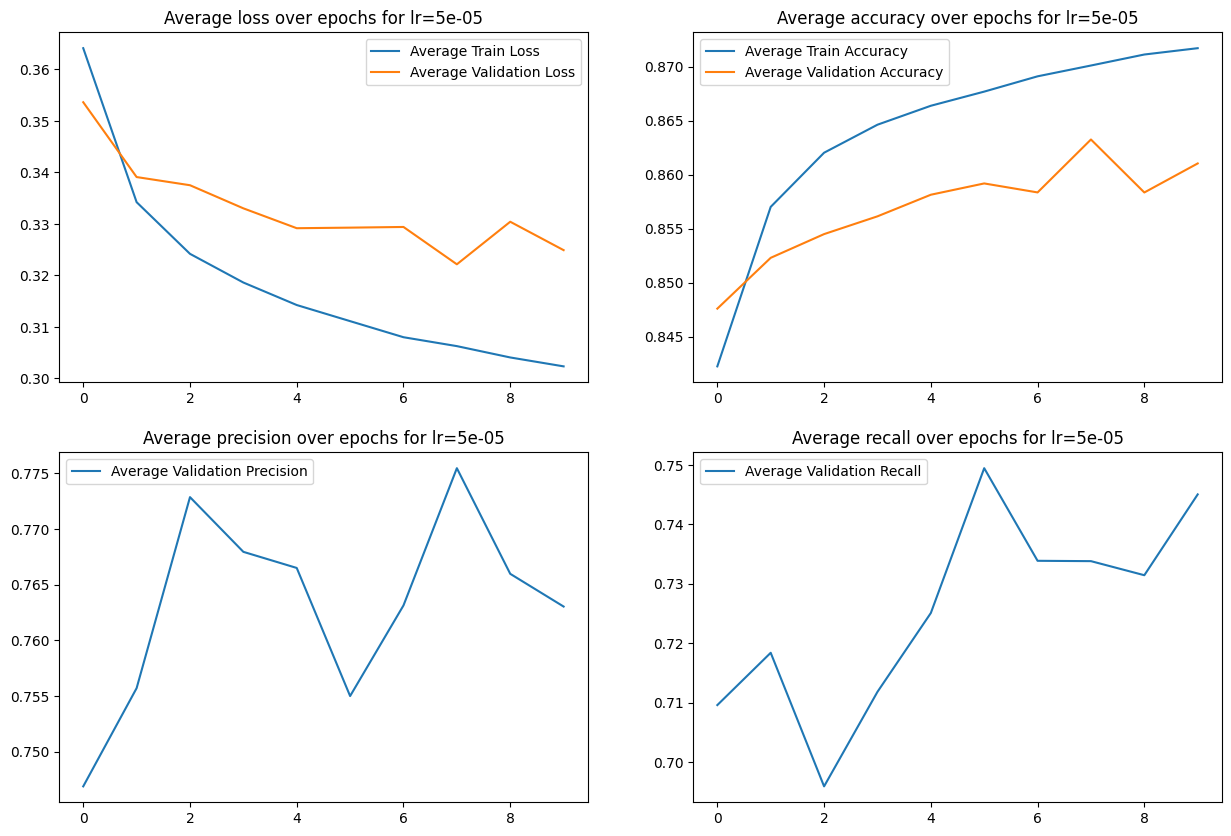

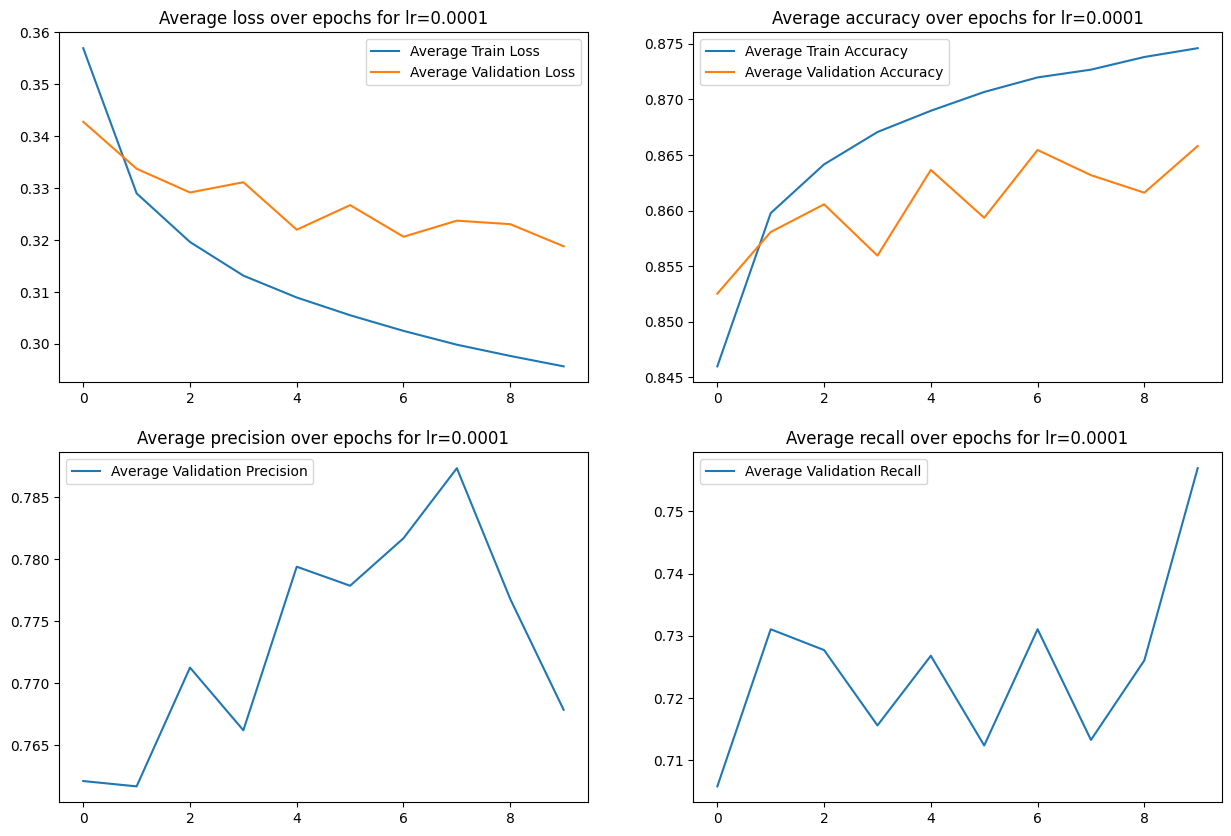

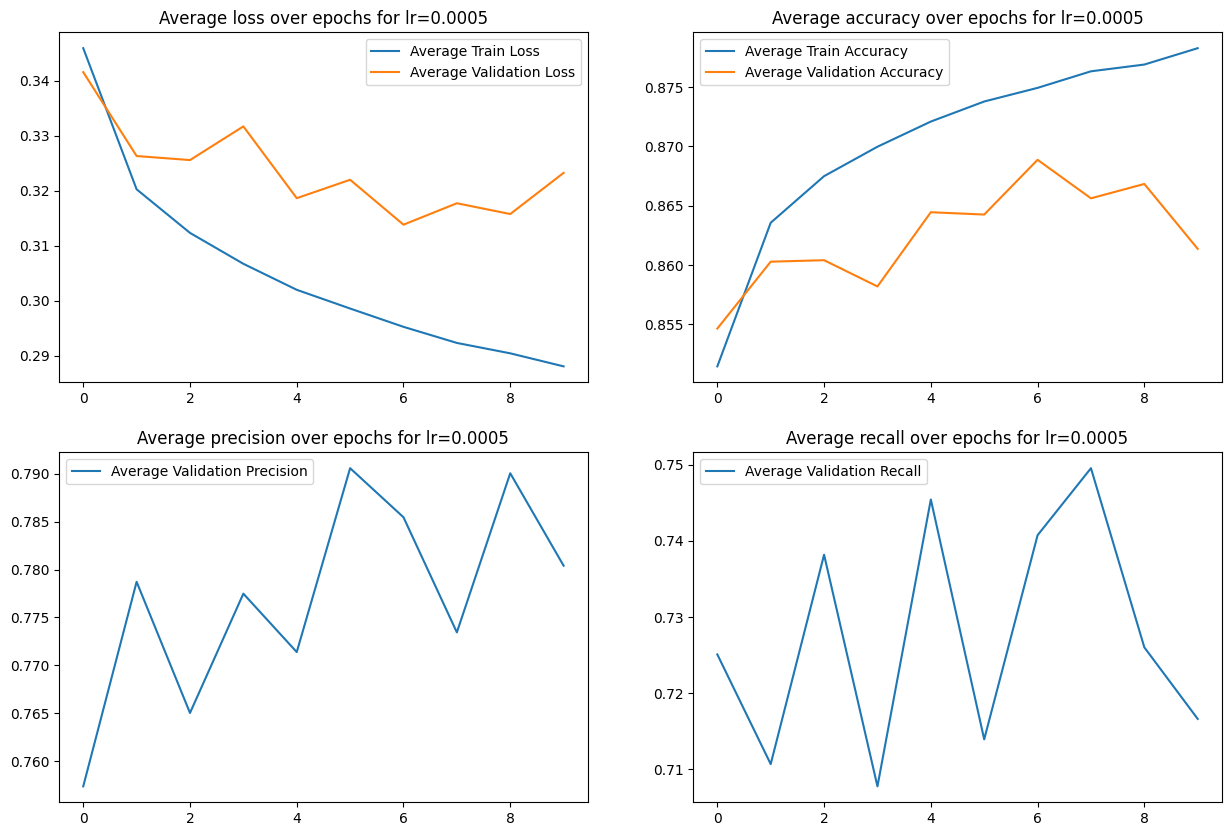

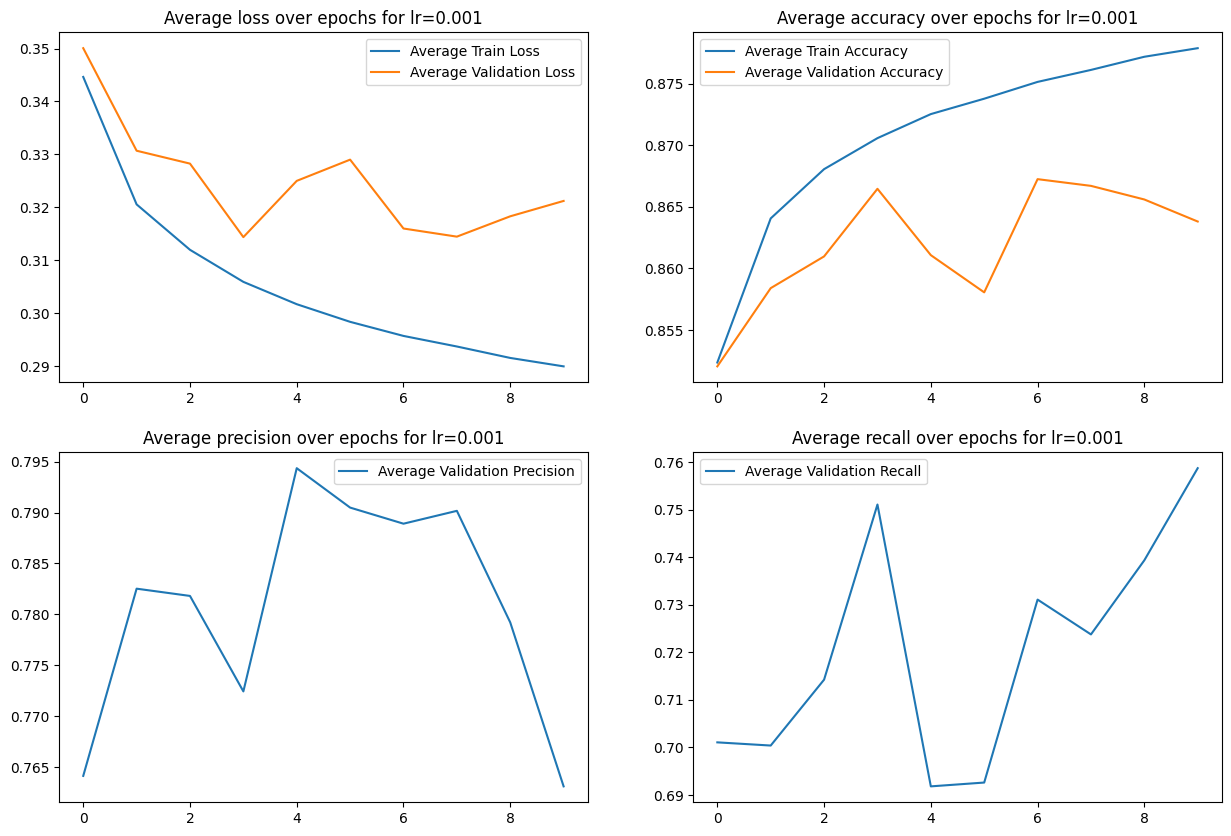

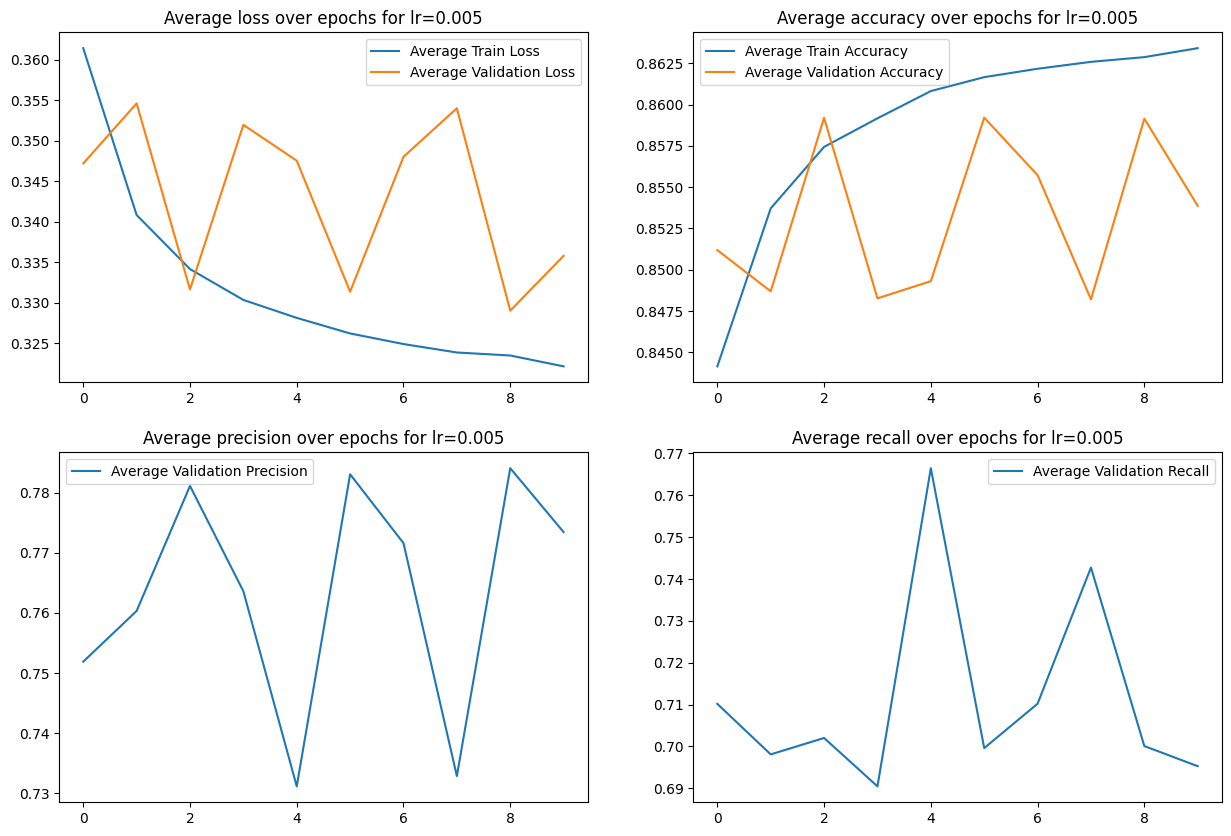

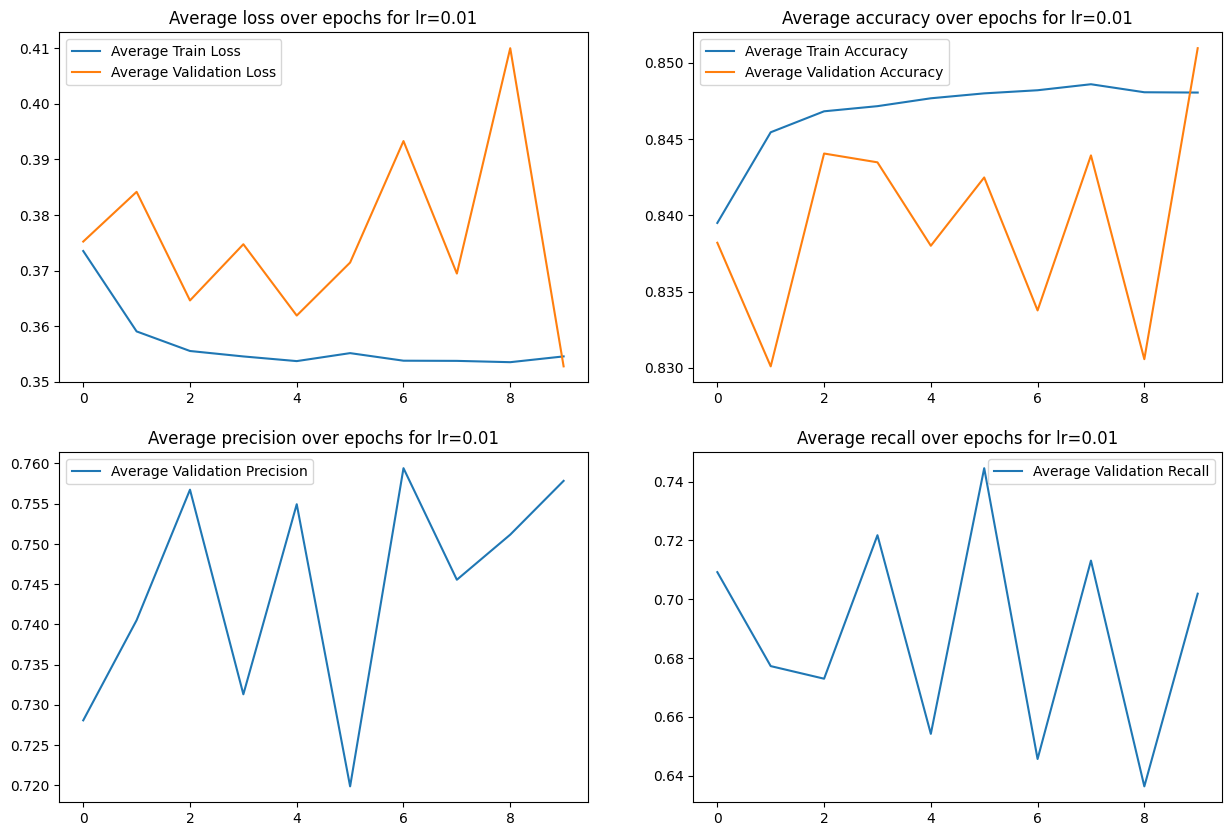

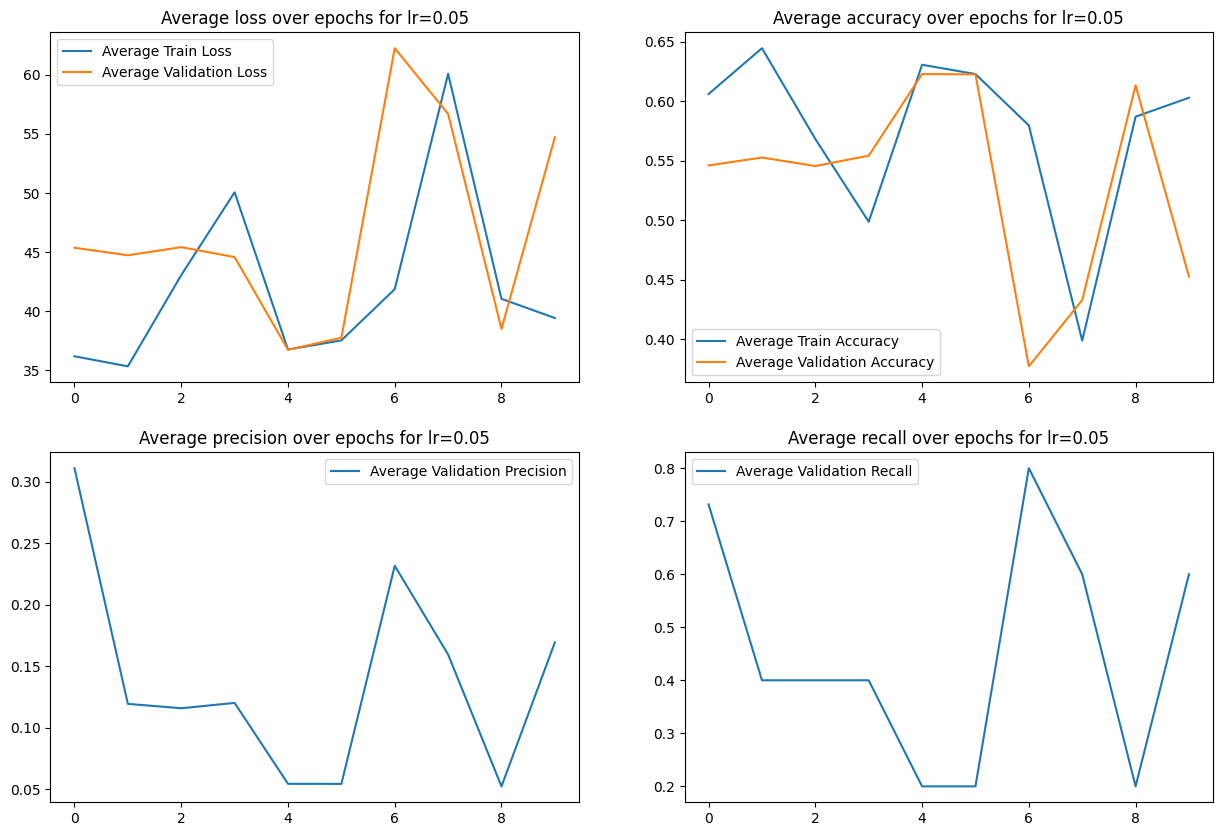

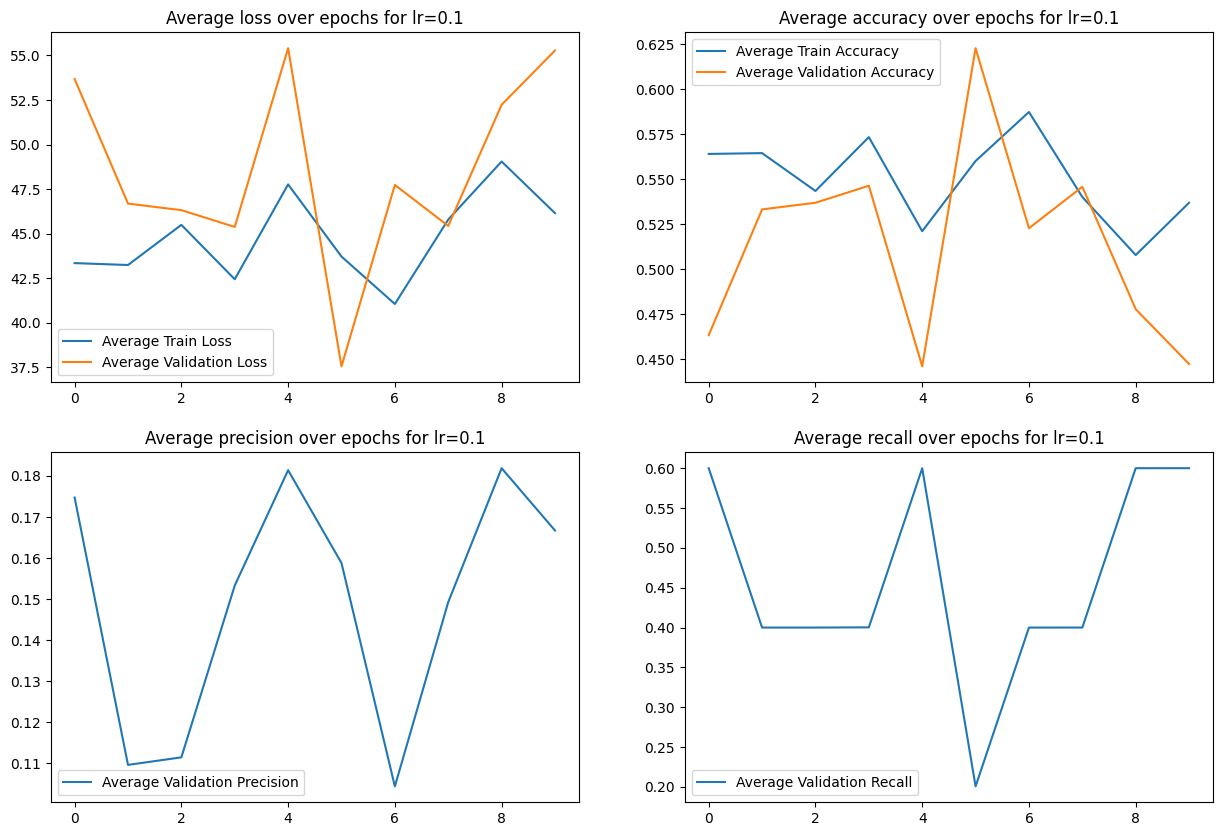

In [7]:
def plot_metrics_by_lr(lr_results):
    # Aggregate metrics by learning rate
    aggregated_metrics = {}
    for metrics in lr_results:
        lr = metrics["lr"]
        if lr not in aggregated_metrics:
            aggregated_metrics[lr] = {
                "train_losses": [],
                "val_losses": [],
                "train_accuracies": [],
                "val_accuracies": [],
                "val_precisions": [],
                "val_recalls": [],
                "val_f1_scores": []
            }
        for key in aggregated_metrics[lr]:
            aggregated_metrics[lr][key].append(metrics[key])
    
    # Plot averaged metrics for each learning rate
    for lr, metrics in aggregated_metrics.items():
        fig, ax = plt.subplots(2, 2, figsize=(15, 10))
        
        # Calculate the average metrics over k folds
        avg_train_losses = np.mean(metrics["train_losses"], axis=0)
        avg_val_losses = np.mean(metrics["val_losses"], axis=0)
        avg_train_accuracies = np.mean(metrics["train_accuracies"], axis=0)
        avg_val_accuracies = np.mean(metrics["val_accuracies"], axis=0)
        avg_val_precisions = np.mean(metrics["val_precisions"], axis=0)
        avg_val_recalls = np.mean(metrics["val_recalls"], axis=0)
        
        # Plot losses
        ax[0, 0].plot(avg_train_losses, label='Average Train Loss')
        ax[0, 0].plot(avg_val_losses, label='Average Validation Loss')
        ax[0, 0].legend()
        ax[0, 0].set_title(f'Average loss over epochs for lr={lr}')

        # Plot accuracies
        ax[0, 1].plot(avg_train_accuracies, label='Average Train Accuracy')
        ax[0, 1].plot(avg_val_accuracies, label='Average Validation Accuracy')
        ax[0, 1].legend()
        ax[0, 1].set_title(f'Average accuracy over epochs for lr={lr}')
        
        # Plot precisions
        ax[1, 0].plot(avg_val_precisions, label='Average Validation Precision')
        ax[1, 0].legend()
        ax[1, 0].set_title(f'Average precision over epochs for lr={lr}')
        
        # Plot recalls
        ax[1, 1].plot(avg_val_recalls, label='Average Validation Recall')
        ax[1, 1].legend()
        ax[1, 1].set_title(f'Average recall over epochs for lr={lr}')
        
        plt.show()

plot_metrics_by_lr(lr_results, k_folds=k_folds)

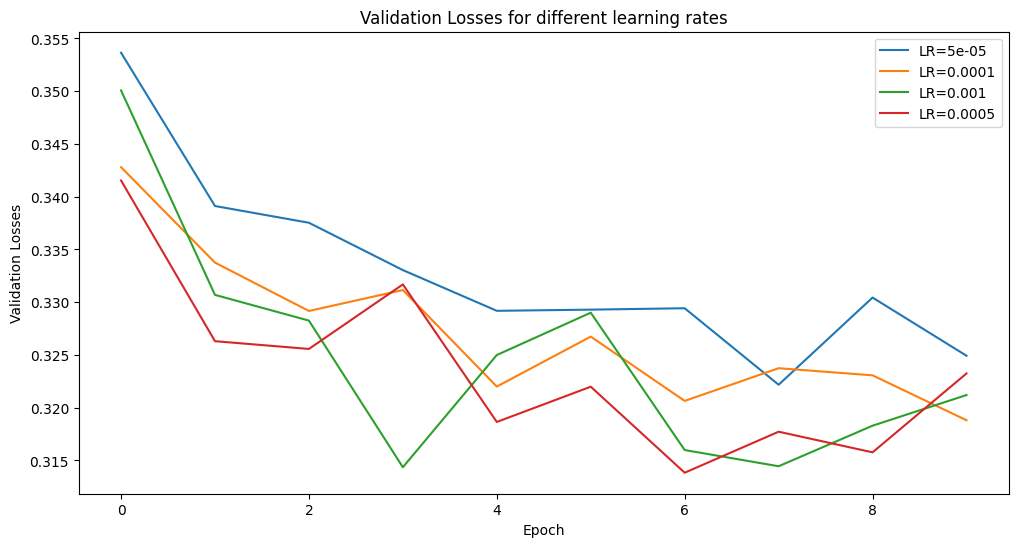

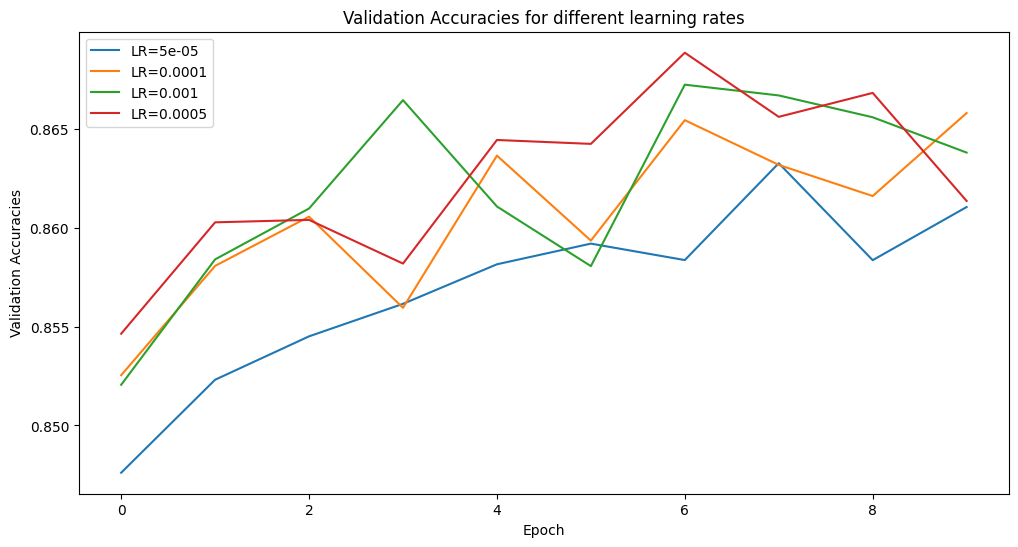

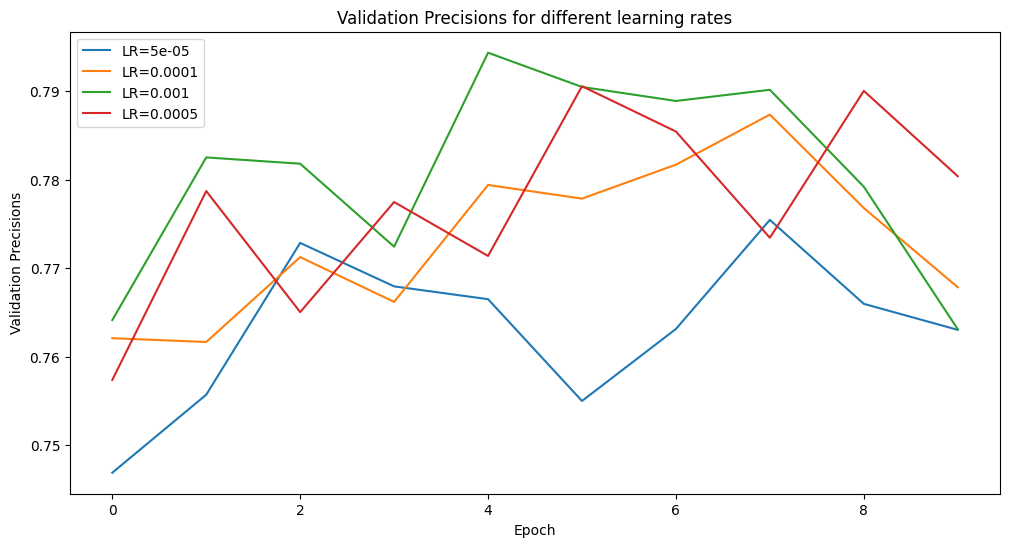

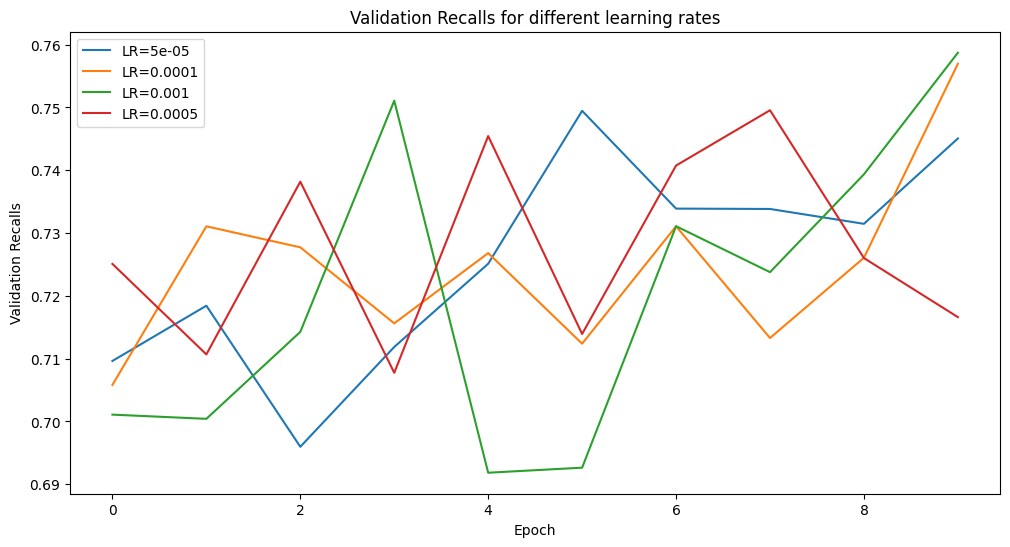

In [6]:
def plot_metrics_by_lr(lr_results, discarded_lr=[]):
    metrics = ["val_losses", "val_accuracies", "val_precisions", "val_recalls"]
    metric_names = ["Validation Losses", "Validation Accuracies", "Validation Precisions", "Validation Recalls"]
    
    for idx, metric in enumerate(metrics):
        plt.figure(figsize=(12, 6))
        for lr in set(result["lr"] for result in lr_results): # Get unique learning rates
            if lr in discarded_lr:
                continue
            metric_values = [result[metric] for result in lr_results if result["lr"] == lr]
            avg_metric_values = np.mean(metric_values, axis=0) # average over the folds
            plt.plot(avg_metric_values, label=f'LR={lr}')
        
        plt.title(metric_names[idx] + ' for different learning rates')
        plt.xlabel('Epoch')
        plt.ylabel(metric_names[idx])
        plt.legend()
        plt.show()


plot_metrics_by_lr(lr_results, discarded_lr=[0.1, 0.05, 0.01, 0.005])
